In [1]:
# Add root folder to python path
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

# Add some common packages
import numpy as np
import pandas as pd
import math
import scipy.stats as ss
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Set up the failure mode class
from pof.failure_mode import FailureMode
from pof.condition import Condition

fm = FailureMode(alpha=50, beta=1.5, gamma=10)

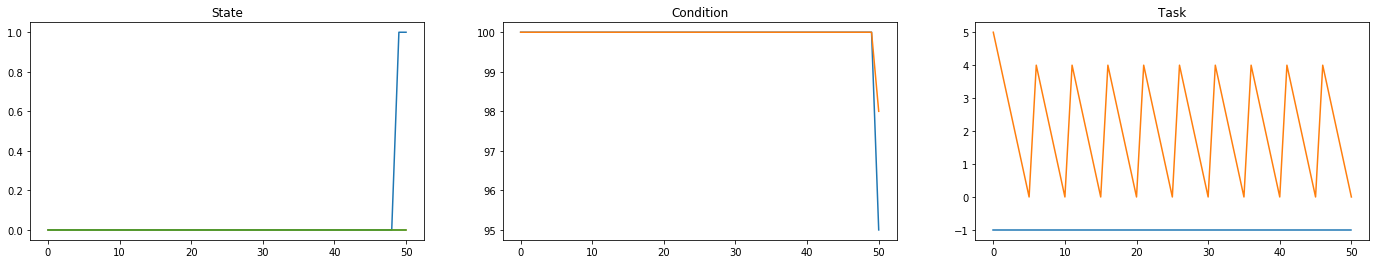

In [3]:
timeline = fm.sim_timeline(50, 0)
fm.plot_timeline()

In [10]:
t_now = 0
t_end = 100

timeline = fm.sim_timeline(t_start=t_now, t_end=t_end)

while t_now < t_end:
    print('sim %s' %(t_now))

    # Check when the next task needs to be executed
    t_now, task_names = fm.next_tasks(timeline, t_end)

    for task_name in task_names:
        
        # Execute the task
        print('execute %s', %(task))
        states = fm.tasks[task_name].sim_completion(states = fm.get_states(), conditions = fm.conditions)#sim_completion(t_end=t_end, timeline=timeline)
        fm.update_timeline(t_start=t_now, t_end=t_end, states_to_update=states)

SyntaxError: invalid syntax (<ipython-input-10-c725c38b0ef6>, line 15)

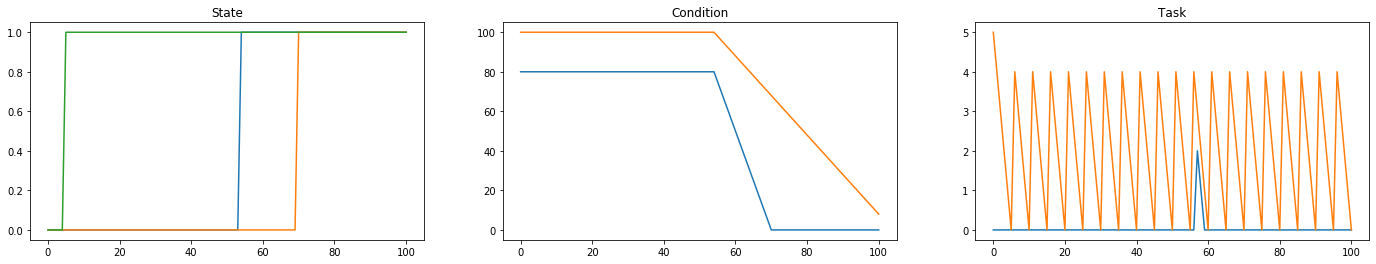

In [5]:
fm.conditions['wall_thickness'].set_condition(80)
fm.conditions['wall_thickness'].set_condition_profile()
fm.sim_timeline(100)
fm.plot_timeline()

In [6]:
abc = fm.tasks['ocr'].sim_timeline(timeline=fm.sim_timeline(50), t_end = 50)

In [7]:
abc = (~abc).astype(int)

In [9]:
fm.next_tasks(timeline, 50)

ValueError: min() arg is an empty sequence

In [7]:
tasks

NameError: name 'tasks' is not defined

array([-2147483648, -2147483648, -2147483648, -2147483648, -2147483648,
       -2147483648, -2147483648, -2147483648, -2147483648, -2147483648,
                 0,           0,           0,           0,           0,
                 0,           0,           0,           0,           0,
                 0,           0,           0,           0,           0,
                 0,           0,           0,           0,           0,
                 0,           0,           0,           0,           0,
                 0,           0,           0,           0,           0,
                 0,           0,           0,           0,           0,
                 0,           0,           0,           0,           0,
                 0])